2-1

Dataset already exists.
Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


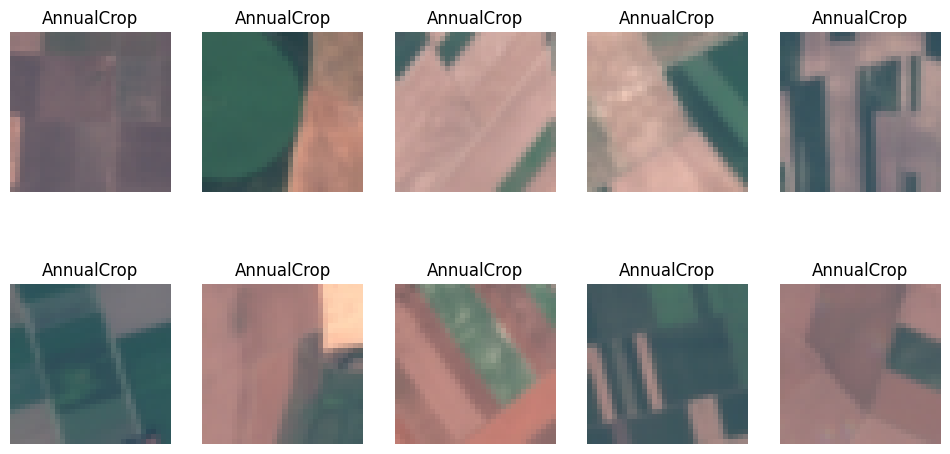

Train dataset size: 18900
Validation dataset size: 5399
Test dataset size: 2701


In [2]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt

# 데이터셋 다운로드 함수
def get_EuroSAT(dirname):
    import os
    if os.path.exists(dirname):
        print("Dataset already exists.")
        return os.path.join(dirname, '2750')
    os.makedirs(dirname, exist_ok=True)
    torchvision.datasets.utils.download_and_extract_archive(
        "http://madm.dfki.de/files/sentinel/EuroSAT.zip",
        download_root=dirname,
        md5="c8fa014336c82ac7804f0398fcb19387",
        remove_finished=True,
    )
    return os.path.join(dirname, '2750')

# 데이터 전처리 정의
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 데이터셋 로드
dataset_path = get_EuroSAT('EuroSAT')
dataset = ImageFolder(dataset_path, transform=transform)
dataset_size = len(dataset)

# 클래스 확인 및 시각화
class_names = dataset.classes
print("Classes:", class_names)

# 샘플 이미지 시각화
def visualize_samples(dataset, num_samples=10):
    plt.figure(figsize=(12, 6))
    for i in range(num_samples):
        img, label = dataset[i]
        img = img.permute(1, 2, 0) * 0.5 + 0.5  # 디노멀라이즈
        plt.subplot(2, 5, i + 1)
        plt.imshow(img.numpy())
        plt.title(class_names[label])
        plt.axis('off')
    plt.show()

visualize_samples(dataset)

# 데이터셋 분할
train_split = 0.7
val_split = 0.2
test_split = 0.1

split1 = int(np.floor(train_split * dataset_size))
split2 = int(np.floor((train_split + val_split) * dataset_size))

indices = np.random.permutation(dataset_size)
train_indices = indices[:split1]
val_indices = indices[split1:split2]
test_indices = indices[split2:]

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# 데이터셋 크기 확인
print('Train dataset size:', len(train_dataset))
print('Validation dataset size:', len(val_dataset))
print('Test dataset size:', len(test_dataset))

# 데이터 로더 설정
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


2-2

In [7]:
# MLP 모델 정의
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

        # Input size is 3 (RGB channels) * 32 * 32 = 3072
        self.fc1 = nn.Linear(3 * 32 * 32, 512)  # 첫 번째 레이어: 입력 -> 은닉층
        self.fc2 = nn.Linear(512, 256)         # 두 번째 레이어: 은닉층 -> 은닉층
        self.fc3 = nn.Linear(256, 128)         # 세 번째 레이어: 은닉층 -> 은닉층
        self.fc4 = nn.Linear(128, 10)          # 네 번째 레이어: 은닉층 -> 출력 (클래스 개수: 10)

        # 활성화 함수
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # Dropout for regularization

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input

        # Feedforward through the layers with activation
        x = self.activation(self.fc1(x))
        x = self.dropout(x)  # Dropout for regularization
        x = self.activation(self.fc2(x))
        x = self.dropout(x)  # Dropout
        x = self.activation(self.fc3(x))
        x = self.fc4(x)  # No activation in the last layer

        return x

# 모델 초기화
model = MLP().to(device)

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 데이터셋 로드 예시
# dataloaders = {'train': train_loader, 'val': val_loader}

# 모델 학습
# train_model(model, dataloaders, criterion, optimizer, num_epochs=10)

2-3

In [5]:
# CNN 모델 정의
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)  # 첫 번째 Conv 레이어
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) # 두 번째 Conv 레이어

        # Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # MaxPooling
        self.dropout = nn.Dropout(0.5)  # Dropout for regularization

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 256)  # Conv2D 출력 크기 기반 Fully Connected 레이어
        self.fc2 = nn.Linear(256, 10)  # 출력 클래스 개수 (EuroSAT: 10개 클래스)

        # Activation
        self.activation = nn.ReLU()

    def forward(self, x):
        # Convolutional layers + Activation + Pooling
        x = self.activation(self.conv1(x))
        x = self.pool(x)
        x = self.activation(self.conv2(x))
        x = self.pool(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers + Activation
        x = self.activation(self.fc1(x))
        x = self.dropout(x)  # Dropout for regularization
        x = self.fc2(x)  # 마지막 레이어에서는 활성화 함수 없음 (softmax는 CrossEntropyLoss에서 처리)

        return x

# 모델 초기화
model = CNN().to(device)

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 데이터셋 로드
dataloaders = {'train': train_loader, 'val': val_loader}

# 모델 학습
# train_model(model, dataloaders, criterion, optimizer, num_epochs=10)

2-4

MLP(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)
Epoch 1/20: Train Loss: 1.8359, Train Accuracy: 0.3076, Val Loss: 1.5211, Val Accuracy: 0.4386
Epoch 2/20: Train Loss: 1.5683, Train Accuracy: 0.4284, Val Loss: 1.4170, Val Accuracy: 0.5421
Epoch 3/20: Train Loss: 1.4798, Train Accuracy: 0.4628, Val Loss: 1.3106, Val Accuracy: 0.5277
Epoch 4/20: Train Loss: 1.4384, Train Accuracy: 0.4809, Val Loss: 1.2611, Val Accuracy: 0.5751
Epoch 5/20: Train Loss: 1.3890, Train Accuracy: 0.5006, Val Loss: 1.2822, Val Accuracy: 0.5401
Epoch 6/20: Train Loss: 1.3683, Train Accuracy: 0.5079, Val Loss: 1.2526, Val Accuracy: 0.5377
Epoch 7/20: Train Loss: 1.3510, Train Accuracy: 0.5161, Val Loss: 1.2095, Val Accuracy: 0.5807
Epoch 8/20: Tr

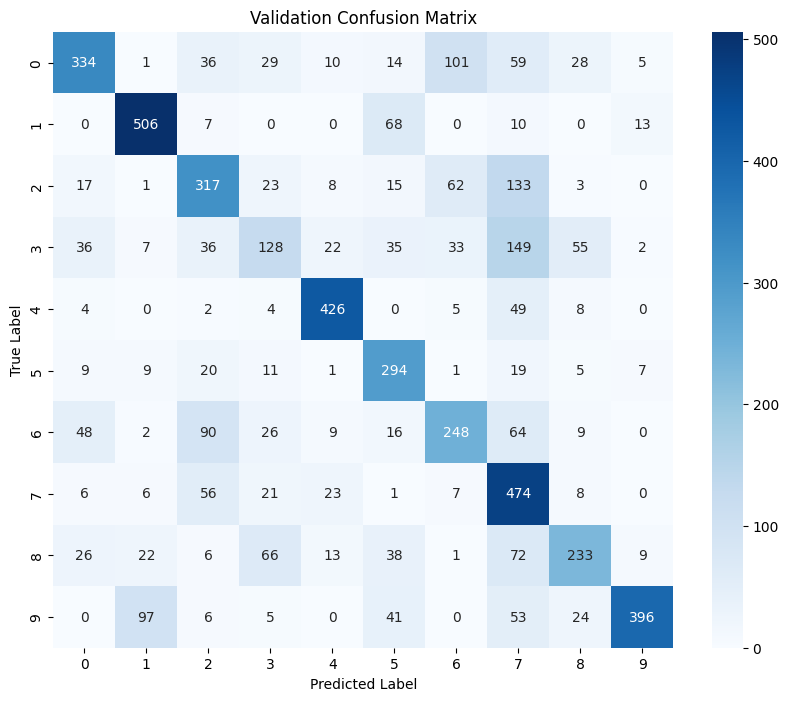

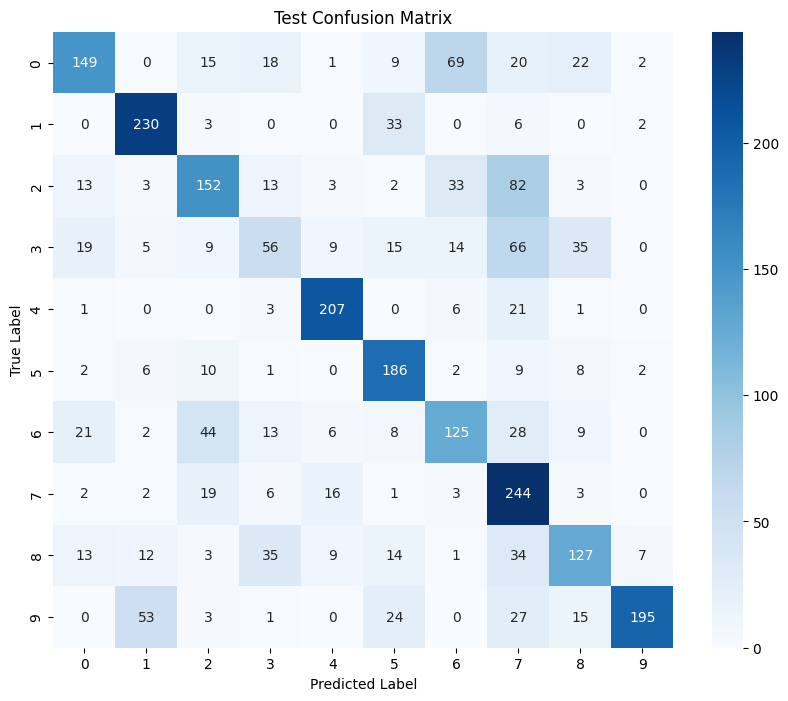

In [8]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 최적화 함수 정의
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer 사용
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss 정의
print(model)

# 학습 함수
def train(model, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    all_predictions = []
    all_labels = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        all_predictions.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = accuracy_score(all_labels, all_predictions)
    return train_loss, train_accuracy


# 검증 및 테스트 함수
def validate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = running_loss / len(val_loader.dataset)
    val_accuracy = accuracy_score(all_labels, all_predictions)
    confusion_mat = confusion_matrix(all_labels, all_predictions)
    return val_loss, val_accuracy, confusion_mat


# 학습 실행
num_epochs = 20  # 적절히 조정 가능
best_val_accuracy = 0.0
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion)
    val_loss, val_accuracy, val_confusion_matrix = validate(model, val_loader, criterion)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = model.state_dict()  # Best model 저장

    print(f"Epoch {epoch + 1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Best 모델 테스트
model.load_state_dict(best_model)  # Best 모델 로드
test_loss, test_accuracy, test_confusion_matrix = validate(model, test_loader, criterion)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Confusion Matrix 시각화
def plot_confusion_matrix(confusion_matrix, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Validation Confusion Matrix
plot_confusion_matrix(val_confusion_matrix, "Validation Confusion Matrix")

# Test Confusion Matrix
plot_confusion_matrix(test_confusion_matrix, "Test Confusion Matrix")
